--- 机构初始状态 ---
初始连杆长度: [2.23606798 2.06155281 1.5        3.        ]

--- 开始模拟 ---
--- 模拟完成 ---

--- 节点 1 在 t=1.00s 的PVA分析 ---
位置 r = (0.316, 2.214) m
速度 v = (-0.418, 0.059) m/s
加速度 a = (0.789, -0.190) m/s^2


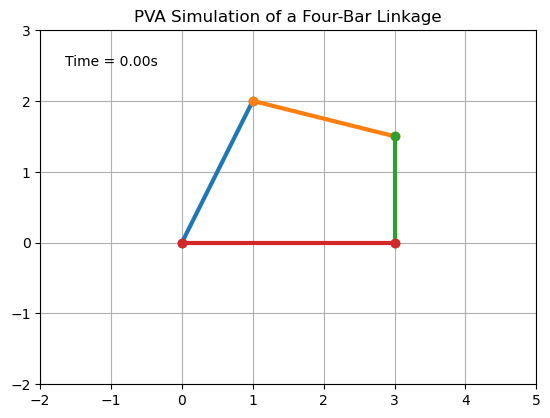

In [2]:
# 
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# =============================================================================
# Section 1: 定义机构和模拟参数 (Define Mechanism and Simulation Parameters)
# =============================================================================

# 1.1 定义机构的初始几何形状
# 使用复数 (x + yj) 来表示每个节点的初始位置
initial_node_positions = np.array([
    0.0 + 0.0j,  # 节点 0 (x0, y0) - 固定在原点
    1.0 + 2.0j,  # 节点 1 (x1, y1) - 浮动点
    3.0 + 1.5j,  # 节点 2 (x2, y2) - 曲柄上的点
    3.0 + 0.0j,  # 节点 3 (x3, y3) - 固定在x轴上
], dtype=complex)

# 1.2 定义连杆如何连接节点
# [[节点A, 节点B], [节点C, 节点D], ...]
# 注意：Python 索引从 0 开始
connectivity_matrix = np.array([
    [0, 1],  # 连杆 0: 连接 节点0 和 节点1
    [1, 2],  # 连杆 1: 连接 节点1 和 节点2
    [2, 3],  # 连杆 2: 连接 节点2 和 节点3 (曲柄)
    [3, 0],  # 连杆 3: 连接 节点3 和 节点0 (机架/地)
])

# 1.3 定义机构的属性
ground_links_idx = [3]  # 连杆 3 是固定的机架
crank_link_idx = 2      # 连杆 2 是输入曲柄
motor_node_idx = 3      # 电机位于节点 3

# 1.4 设置模拟参数
t_period = 10.0  # 总模拟时间 (秒)
dt = 0.01        # 时间步长 (秒)
crank_angular_velocity_deg = 36  # 曲柄角速度 (度/秒)

# =============================================================================
# Section 2: 初始化计算 (Initialization and "Book-keeping")
# =============================================================================

# 将角速度从 度/秒 转换为 弧度/秒
omega_rad_per_sec = np.deg2rad(crank_angular_velocity_deg)

# 计算初始连杆长度 (这是整个模拟中需要保持不变的量)
num_links = len(connectivity_matrix)
initial_link_lengths = np.zeros(num_links)
for i in range(num_links):
    node1_idx = connectivity_matrix[i, 0]
    node2_idx = connectivity_matrix[i, 1]
    p1 = initial_node_positions[node1_idx]
    p2 = initial_node_positions[node2_idx]
    initial_link_lengths[i] = np.abs(p2 - p1) # np.abs for complex number is its magnitude

print("--- 机构初始状态 ---")
print(f"初始连杆长度: {initial_link_lengths}\n")

# 创建时间数组
time_steps = np.arange(0, t_period, dt)

# 创建一个数组来存储每个时间步的节点位置
num_nodes = len(initial_node_positions)
node_positions_over_time = np.zeros((len(time_steps), num_nodes), dtype=complex)
node_positions_over_time[0, :] = initial_node_positions

# 识别哪些节点是固定的，哪些是需要计算的
# 固定的节点
ground_nodes = np.unique(connectivity_matrix[ground_links_idx])
# 曲柄上，非电机所在的那个点
crank_node_idx = connectivity_matrix[crank_link_idx, 0] if connectivity_matrix[crank_link_idx, 1] == motor_node_idx else connectivity_matrix[crank_link_idx, 1]
# 真正需要用求解器计算的浮动节点 (在这个例子中是节点 1)
floating_nodes_idx = [i for i in range(num_nodes) if i not in ground_nodes and i != crank_node_idx]

# =============================================================================
# Section 3: 目标/误差函数 (Objective Function)
# =============================================================================
def link_length_difference(dx_guess, current_positions, floating_node_idx, connected_links_info, target_lengths):
    """
    这个函数是数值求解器的核心。
    它计算当浮动点移动一个猜测的位移 dx_guess 后，相关连杆的长度与原始长度的误差。
    """
    # 将猜测的位移 (一个包含实部和虚部的数组 [dx_real, dx_imag]) 转换为复数
    dx_complex = dx_guess[0] + 1j * dx_guess[1]
    
    # 创建一个副本以避免修改原始数据
    temp_positions = current_positions.copy()
    temp_positions[floating_node_idx] += dx_complex
    
    errors = []
    # 遍历所有与浮动点相连的连杆
    for i, link_info in enumerate(connected_links_info):
        link_idx = link_info['link_idx']
        node1_idx, node2_idx = connectivity_matrix[link_idx]
        
        # 计算新的连杆长度
        p1 = temp_positions[node1_idx]
        p2 = temp_positions[node2_idx]
        new_length = np.abs(p2 - p1)
        
        # 计算误差
        error = new_length - target_lengths[i]
        errors.append(error)
        
    return errors

# =============================================================================
# Section 4: 主模拟循环 (Main Simulation Loop)
# =============================================================================
print("--- 开始模拟 ---")
# 找到与浮动节点 (节点1) 相连的连杆 (连杆0 和 连杆1)
floating_node_idx = floating_nodes_idx[0] # 我们假设只有一个浮动点
connected_links_info = []
for i in range(num_links):
    if floating_node_idx in connectivity_matrix[i]:
        connected_links_info.append({'link_idx': i})

target_lengths_for_solver = [initial_link_lengths[info['link_idx']] for info in connected_links_info]


for t_idx in range(1, len(time_steps)):
    # 从上一个时间步获取位置
    previous_positions = node_positions_over_time[t_idx-1, :].copy()
    current_positions = previous_positions.copy()

    # 4.1 驱动曲柄: 旋转曲柄节点
    # 曲柄向量是从电机节点指向曲柄节点的
    crank_vector = previous_positions[crank_node_idx] - previous_positions[motor_node_idx]
    # 计算旋转角度
    d_theta = omega_rad_per_sec * dt
    # 进行旋转 (复数乘法)
    rotated_crank_vector = crank_vector * np.exp(1j * d_theta)
    # 更新曲柄节点的位置
    current_positions[crank_node_idx] = previous_positions[motor_node_idx] + rotated_crank_vector
    
    # 4.2 求解从动点: 使用非线性求解器找到浮动点的位置
    # 初始猜测：假设浮动点没有移动 (dx = 0)
    dx_initial_guess = [0, 0] 
    
    # 调用求解器
    result = least_squares(
        link_length_difference,
        dx_initial_guess,
        args=(current_positions, floating_node_idx, connected_links_info, target_lengths_for_solver)
    )
    
    # 提取求解器找到的最佳 dx
    dx_solution = result.x[0] + 1j * result.x[1]
    
    # 4.3 更新浮动点的位置
    current_positions[floating_node_idx] += dx_solution
    
    # 存储当前时间步的所有节点位置
    node_positions_over_time[t_idx, :] = current_positions

print("--- 模拟完成 ---\n")

# =============================================================================
# Section 5: 后处理 - 计算速度和加速度 (Post-Processing - PVA)
# =============================================================================
# 使用数值微分 (有限差分法)
velocities = (node_positions_over_time[1:] - node_positions_over_time[:-1]) / dt
accelerations = (velocities[1:] - velocities[:-1]) / dt

# 打印节点1在某个时间点的PVA作为示例
sample_time_idx = 100
print(f"--- 节点 {floating_node_idx} 在 t={time_steps[sample_time_idx]:.2f}s 的PVA分析 ---")
pos_sample = node_positions_over_time[sample_time_idx, floating_node_idx]
vel_sample = velocities[sample_time_idx, floating_node_idx]
accel_sample = accelerations[sample_time_idx, floating_node_idx]
print(f"位置 r = ({pos_sample.real:.3f}, {pos_sample.imag:.3f}) m")
print(f"速度 v = ({vel_sample.real:.3f}, {vel_sample.imag:.3f}) m/s")
print(f"加速度 a = ({accel_sample.real:.3f}, {accel_sample.imag:.3f}) m/s^2")

# =============================================================================
# Section 6: 结果可视化 (Visualization)
# =============================================================================
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-2, 5)
ax.set_ylim(-2, 3)
ax.set_title('PVA Simulation of a Four-Bar Linkage')
ax.grid(True)

# 绘制连杆的线条对象
lines = []
for i in range(num_links):
    node1_idx, node2_idx = connectivity_matrix[i]
    line, = ax.plot([], [], 'o-', lw=3)
    lines.append(line)

time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def animate(frame_idx):
    # 更新每个连杆的位置
    for i in range(num_links):
        node1_idx, node2_idx = connectivity_matrix[i]
        p1 = node_positions_over_time[frame_idx, node1_idx]
        p2 = node_positions_over_time[frame_idx, node2_idx]
        lines[i].set_data([p1.real, p2.real], [p1.imag, p2.imag])
    
    time_text.set_text(f'Time = {time_steps[frame_idx]:.2f}s')
    return lines + [time_text]

ani = FuncAnimation(fig, animate, frames=len(time_steps), interval=dt*1000, blit=True)
plt.show()